# Fine-Tuning ViT for Image Classification



In [1]:


! pip install datasets transformers
! pip install accelerate -U
! pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 1.9 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load a dataset

In [3]:
from datasets import load_dataset
ham_path = "drive/MyDrive/ML_Assignments/ml_ham_final"
ds = load_dataset("imagefolder", data_dir=ham_path)


Resolving data files:   0%|          | 0/8025 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/880 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1103 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

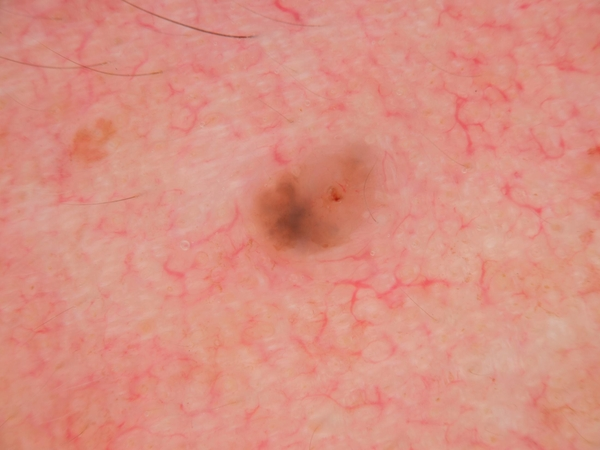

In [4]:
ex = ds['train'][400]
image = ex['image']
image

In [5]:
labels = ds['train'].features['label']
labels

ClassLabel(names=['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'], id=None)

In [6]:
from transformers import ViTFeatureExtractor, AutoImageProcessor
model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [7]:
ds = load_dataset("imagefolder", data_dir=ham_path)

def transform(example_batch):
    inputs = feature_extractor([x for x in example_batch['image']], return_tensors='pt')
    inputs['label'] = example_batch['label']
    return inputs

prepared_ds = ds.with_transform(transform)

Resolving data files:   0%|          | 0/8025 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/880 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1103 [00:00<?, ?it/s]

In [8]:
prepared_ds = ds.with_transform(transform)

In [9]:
import torch
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

In [10]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

<ipython-input-10-3044fb6e3895>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [11]:
from transformers import ViTForImageClassification
from transformers import AutoImageProcessor

labels = ds['train'].features['label'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
from transformers import TrainingArguments
training_args = TrainingArguments(
  output_dir="./vit-base",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=5,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

In [13]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    tokenizer=feature_extractor,
)

In [14]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Step,Training Loss,Validation Loss,Accuracy
100,0.673600,1.125038,0.551136
200,0.748800,1.408226,0.400000
300,0.683900,1.187438,0.656818
400,0.623400,1.116317,0.698864
500,0.511200,1.315672,0.596591
600,0.426600,1.341429,0.575000
700,0.472300,1.142543,0.571591
800,0.572400,1.052480,0.693182
900,0.450300,1.222566,0.631818
1000,0.391200,1.231639,0.663636


***** train metrics *****
  epoch                    =          5.0
  total_flos               = 2895952597GF
  train_loss               =        0.295
  train_runtime            =   0:56:23.41
  train_samples_per_second =       11.859
  train_steps_per_second   =        0.742


In [15]:
metrics = trainer.evaluate(prepared_ds['test'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)
metrics

***** eval metrics *****
  epoch                   =        5.0
  eval_accuracy           =     0.9184
  eval_loss               =      0.269
  eval_runtime            = 0:04:17.77
  eval_samples_per_second =      4.279
  eval_steps_per_second   =      0.535


{'eval_loss': 0.26901668310165405,
 'eval_accuracy': 0.9184043517679057,
 'eval_runtime': 257.7781,
 'eval_samples_per_second': 4.279,
 'eval_steps_per_second': 0.535,
 'epoch': 5.0}

In [16]:
output = trainer.predict(prepared_ds['test'])

In [17]:
from sklearn.metrics import accuracy_score
label_ordering = ds['train'].features['label'].names

target_labels = output.label_ids
prediction_labels = np.argmax(output.predictions, axis=-1)
print(f"Accuracy:  {accuracy_score(target_labels, prediction_labels)}")
label_ordering

Accuracy:  0.9184043517679057


['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

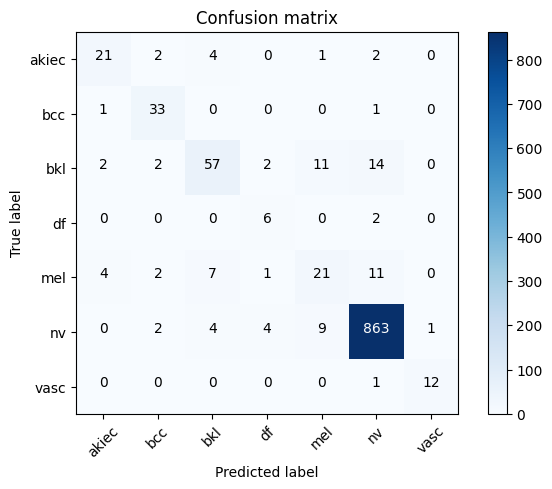

In [18]:
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



confusion_mtx = confusion_matrix(target_labels, prediction_labels)
plot_confusion_matrix(confusion_mtx, label_ordering)


In [19]:
# Generate a classification report
report = classification_report(target_labels, prediction_labels, target_names=label_ordering)
print(report)

              precision    recall  f1-score   support

       akiec       0.75      0.70      0.72        30
         bcc       0.80      0.94      0.87        35
         bkl       0.79      0.65      0.71        88
          df       0.46      0.75      0.57         8
         mel       0.50      0.46      0.48        46
          nv       0.97      0.98      0.97       883
        vasc       0.92      0.92      0.92        13

    accuracy                           0.92      1103
   macro avg       0.74      0.77      0.75      1103
weighted avg       0.92      0.92      0.92      1103



In [20]:
print(f"Model parameters {model.num_parameters()}")

Model parameters 85804039
